# Tarea 3: PINNs, Redes Recurrentes y Transformers

En esta Tarea Trabajaremos Con [Pytorch](https://pytorch.org/), una librería de Deep Learning de código abierto desarrollada por Facebook. Pytorch es una librería de Deep Learning que se basa en el concepto de [Tensores](https://pytorch.org/docs/stable/tensors.html), que son similares a los arreglos de Numpy, pero con la diferencia de que pueden ser utilizados en una GPU para acelerar los cálculos.

Se escogio Pytorch por sobre Tensorflow o Keras ya que tiene un paquete de [diferenciacion automatica](https://pytorch.org/docs/stable/autograd.html) que nos permite calcular derivadas de forma automatica, lo que nos permite implementar de forma sencilla los modelos de redes neuronales y sobre todo trabajar con PINNs y modificar pequeños detalles de forma sencilla en el lopp de entrenamiento como lo es aplicar custom losses, etc.

Dado que la ultima seccion del curso esta enfocado a trabajar con series temporales, todos los problemas en esta tarea de alguna u otra forma estan relacionados con series temporales o secuencias.

# 1. Imports

In [ ]:
#data
import numpy as np
import pandas  as pd

# torch
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(123)

En esta tarea tenemos 2 Secciones obligatorias, la parte de Redes Recurrentes y la Parte de Transformers, pero como no hay desafio Kaggle se añadio una seccion extra sobre PINNS (Physics Informed Neural Networks) la cual es opcional y sirve como bonus para la nota final.

Dado que no hay desafio Kaggle se incentiva a ser creativos y modificar los codigos, esto tambien añadira un bonus para la tarea.

# Parte 2: Redes Recurrentes

En esta tarea no hay desafio kaggle, por lo que en esta seccion deberan utilizar su creatividad para resolver un problema de series temporales, utilizando redes recurrentes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2.1 Cargar Datos

In [ ]:
# Import training set

#ss
#train_path = "/content/drive/MyDrive/Colab Notebooks/tarea3/data/DailyClimate_Train.csv"

#js
train_path = "/content/drive/MyDrive/Tarea 3 INF 395/data/DailyClimate_Train.csv"

train_df= pd.read_csv(train_path)
train_df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [ ]:
# Import test set
#ss
#test_path = "/content/drive/MyDrive/Colab Notebooks/tarea3/data/DailyClimate_test.csv"

#js
test_path = "/content/drive/MyDrive/Tarea 3 INF 395/data/DailyClimate_test.csv"
test_df= pd.read_csv(test_path)
test_df

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


## 2.2 EDA & data Viz

En esta seccion deberan realizar un analisis exploratorio de los datos, generar visualizaciones que les permitan entender mejor los datos con los que estan trabajando y sacar conclusiones de estos.

### Generalidades

In [ ]:
print(train_df.describe())

          meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333


### Histogramas individuales por variable

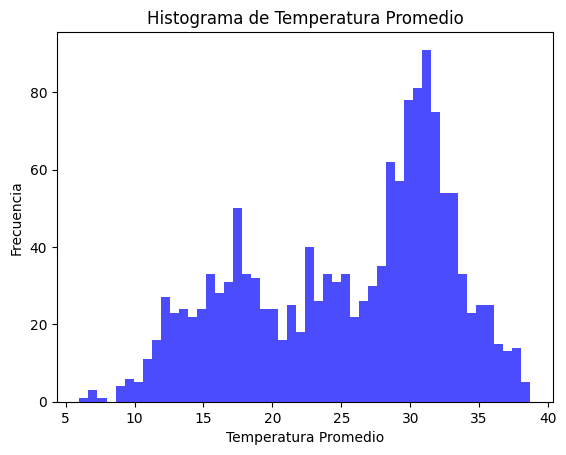

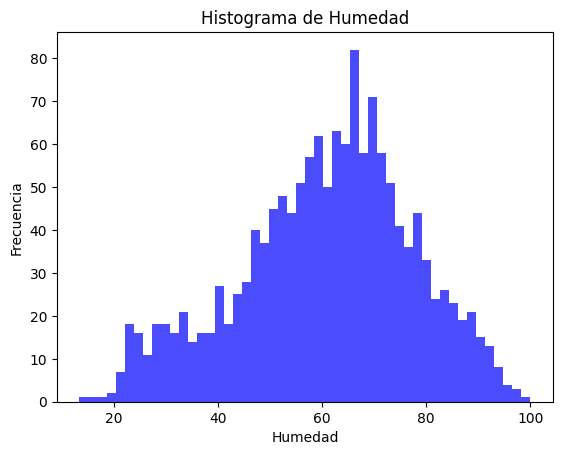

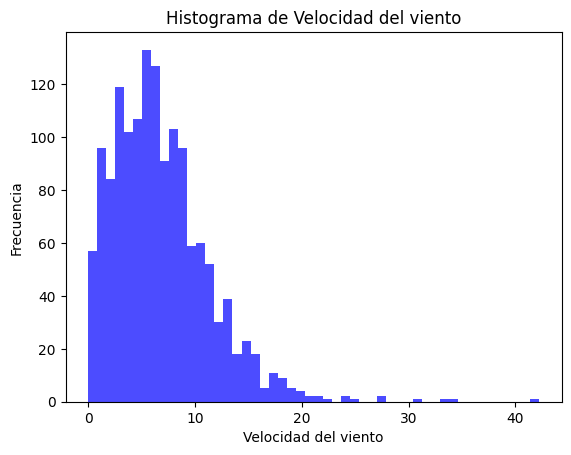

In [ ]:
plt.hist(train_df['meantemp'], bins=50, color='blue', alpha=0.7)
plt.title('Histograma de Temperatura Promedio')
plt.xlabel('Temperatura Promedio')
plt.ylabel('Frecuencia')
plt.show()

plt.hist(train_df['humidity'], bins=50, color='blue', alpha=0.7)
plt.title('Histograma de Humedad')
plt.xlabel('Humedad')
plt.ylabel('Frecuencia')
plt.show()

plt.hist(train_df['wind_speed'], bins=50, color='blue', alpha=0.7)
plt.title('Histograma de Velocidad del viento')
plt.xlabel('Velocidad del viento')
plt.ylabel('Frecuencia')
plt.show()

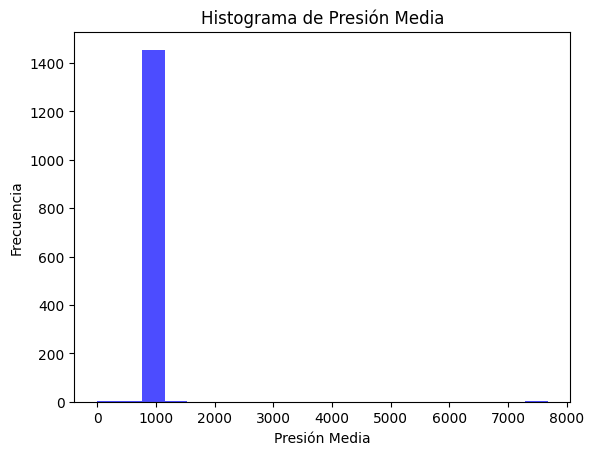

In [ ]:
plt.hist(train_df['meanpressure'], bins=20, color='blue', alpha=0.7)
plt.title('Histograma de Presión Media')
plt.xlabel('Presión Media')
plt.ylabel('Frecuencia')
plt.show()

Aparentemente, y a diferencia de las demás columnas, existen valores atípicos exagerados para la presión media que no permiten una correcta visualización de su comportamiento. Por lo que habrá que aplicar estrategias al respecto.  
  
##Correlación

<ipython-input-9-4fed2b380a8c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


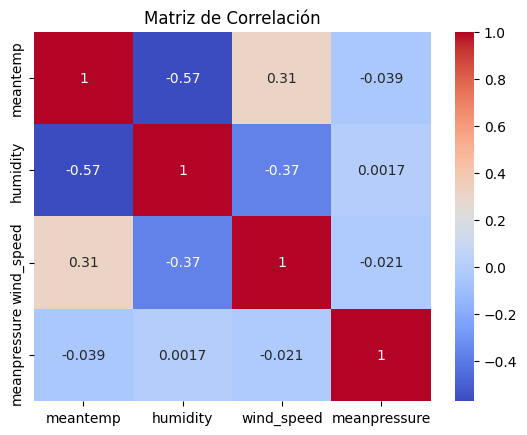

In [ ]:
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

Se observa que la presión promedio es un dato que practicamente no está correlacionado con los demás, mientras que en los otros 3 si se puede ver un cierto nivel de correlación. Esto se puede deber a los outlayers a los que nos referimos anteriormente.


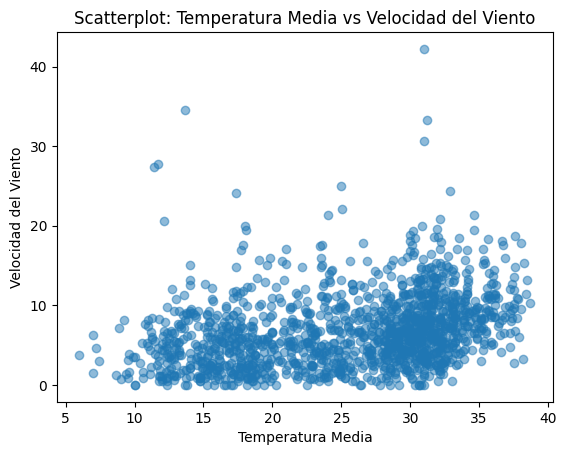

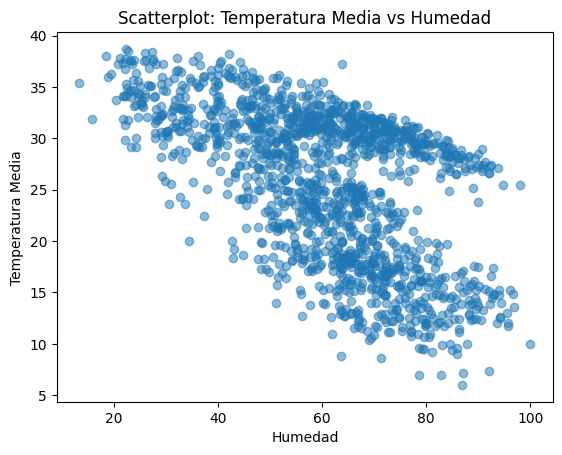

In [ ]:
plt.scatter(train_df['meantemp'], train_df['wind_speed'], alpha=0.5)
plt.title('Scatterplot: Temperatura Media vs Velocidad del Viento')
plt.xlabel('Temperatura Media')
plt.ylabel('Velocidad del Viento')
plt.show()

plt.scatter(train_df['humidity'], train_df['meantemp'], alpha=0.5)
plt.title('Scatterplot: Temperatura Media vs Humedad')
plt.xlabel('Humedad')
plt.ylabel('Temperatura Media')
plt.show()

El último gráfico resulta algo más interesante que lel primero, ya que da la impresión de que existen 2 rectas de aproximacion. Nuestra hipótesis es que podría ser que para determinada tendencia en las otras variables aparezca una de estas, mientras que para otra combinación de valores aparecería la otra.  
  
### Experimentando con la columna de Presión Media

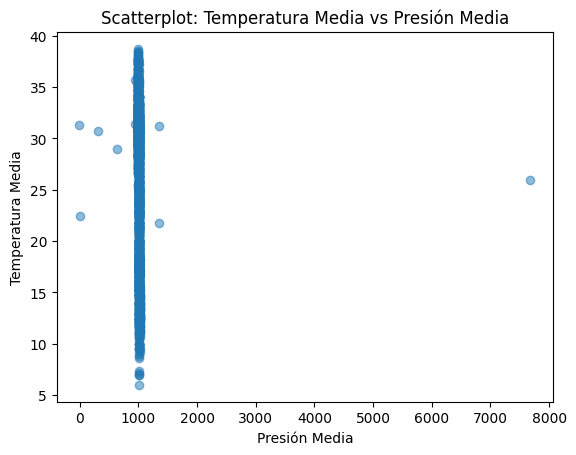

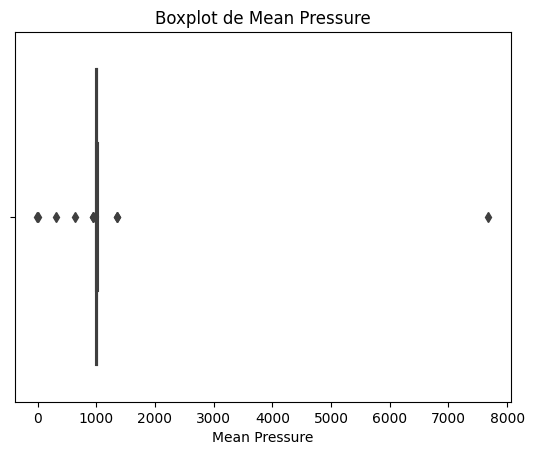

In [ ]:
plt.scatter(train_df['meanpressure'], train_df['meantemp'], alpha=0.5)
plt.title('Scatterplot: Temperatura Media vs Presión Media')
plt.xlabel('Presión Media')
plt.ylabel('Temperatura Media')
plt.show()

sns.boxplot(x=train_df['meanpressure'])
plt.title('Boxplot de Mean Pressure')
plt.xlabel('Mean Pressure')
plt.show()

En estos gráficos se puede visualizar con certeza la existencia de un pequeño conjunto de datos atípicos, la pregunta es ¿como se comportarán el histograma correspondiente, el scatterplot con la temperatura media y la matriz de correlación sin la existencia de estos valores?

In [ ]:
condicion = (train_df['meanpressure'] >= 950) & (train_df['meanpressure'] <= 1100)
df_exp = train_df.loc[condicion]

<ipython-input-13-2916a98ba422>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_exp.corr()


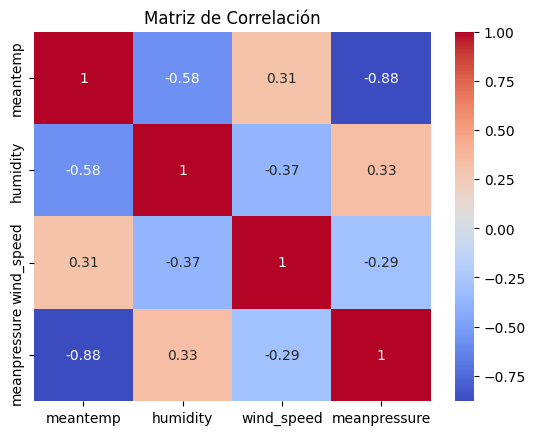

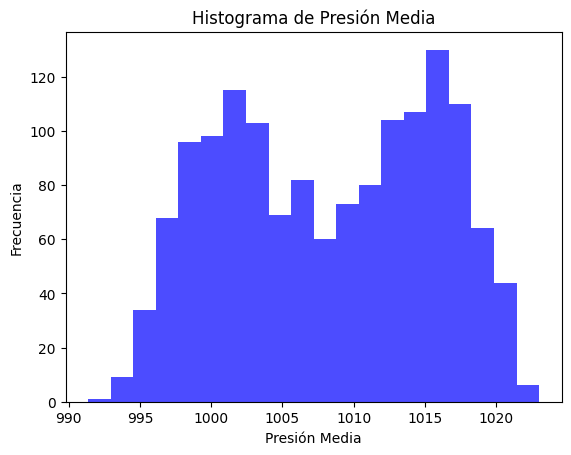

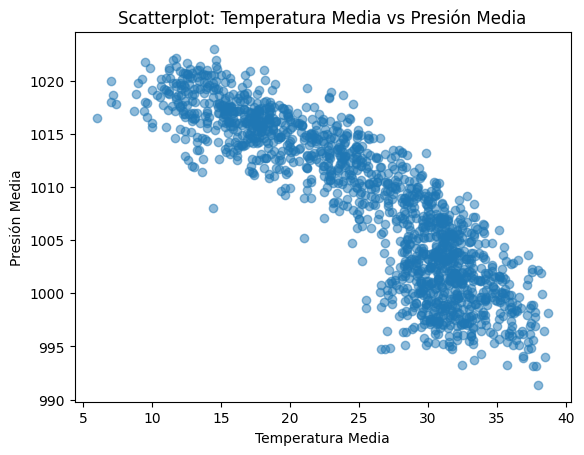

In [ ]:
correlation_matrix = df_exp.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

plt.hist(df_exp['meanpressure'], bins=20, color='blue', alpha=0.7)
plt.title('Histograma de Presión Media')
plt.xlabel('Presión Media')
plt.ylabel('Frecuencia')
plt.show()

plt.scatter(df_exp['meantemp'], df_exp['meanpressure'], alpha=0.5)
plt.title('Scatterplot: Temperatura Media vs Presión Media')
plt.xlabel('Temperatura Media')
plt.ylabel('Presión Media')
plt.show()

Una vez se eliminan los outlayers, es fácilmente reconocible la existencia de una correlación, por lo menos a un grado para tomar en cuenta.  
  
### Influencia del momento del año

In [ ]:
df_exp['date'] = pd.to_datetime(df_exp['date'])
df_exp['month'] = df_exp['date'].dt.month

print(df_exp[['date', 'month']])

           date  month
0    2013-01-01      1
1    2013-01-02      1
2    2013-01-03      1
3    2013-01-04      1
4    2013-01-05      1
...         ...    ...
1457 2016-12-28     12
1458 2016-12-29     12
1459 2016-12-30     12
1460 2016-12-31     12
1461 2017-01-01      1

[1453 rows x 2 columns]


<ipython-input-14-080cf18d1346>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['date'] = pd.to_datetime(df_exp['date'])
<ipython-input-14-080cf18d1346>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['month'] = df_exp['date'].dt.month


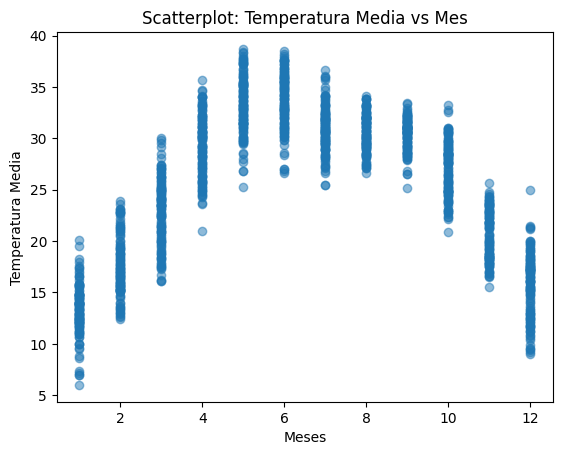

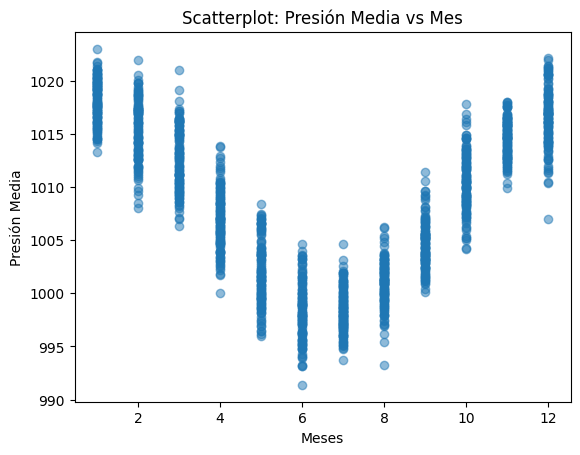

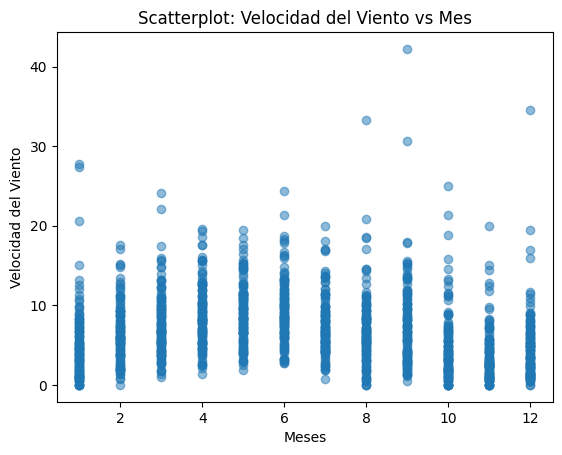

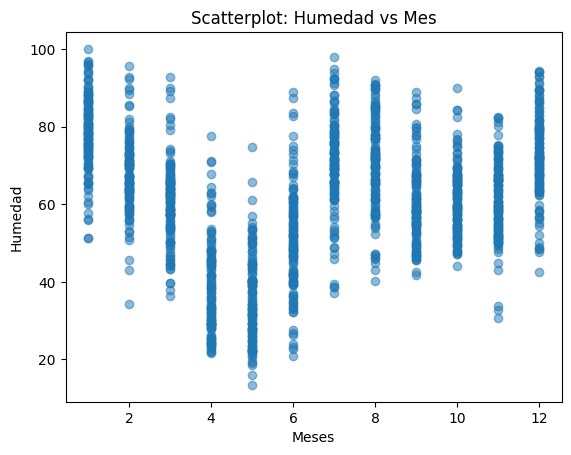

In [ ]:
plt.scatter(df_exp['month'], df_exp['meantemp'], alpha=0.5)
plt.title('Scatterplot: Temperatura Media vs Mes')
plt.xlabel('Meses')
plt.ylabel('Temperatura Media')
plt.show()

plt.scatter(df_exp['month'], df_exp['meanpressure'], alpha=0.5)
plt.title('Scatterplot: Presión Media vs Mes')
plt.xlabel('Meses')
plt.ylabel('Presión Media')
plt.show()

plt.scatter(df_exp['month'], df_exp['wind_speed'], alpha=0.5)
plt.title('Scatterplot: Velocidad del Viento vs Mes')
plt.xlabel('Meses')
plt.ylabel('Velocidad del Viento')
plt.show()

plt.scatter(df_exp['month'], df_exp['humidity'], alpha=0.5)
plt.title('Scatterplot: Humedad vs Mes')
plt.xlabel('Meses')
plt.ylabel('Humedad')
plt.show()

Los meses pueden de alguna manera representar la ubicación respecto a las estaciones del año, lo cual es un dato relevante a considerar para predecir la temperatura. Frente a esto consideraremos implementar un encoding cíclico para los 365 o 366 día del año.

In [ ]:
df_exp['day_of_year'] = df_exp['date'].dt.dayofyear
df_exp['year'] = df_exp['date'].dt.year

df_exp['theta'] = np.where(df_exp['year'] == 2016,
                           2 * np.pi * (df_exp['day_of_year'] - 1) / 366,
                           2 * np.pi * (df_exp['day_of_year'] - 1) / 365)

df_exp['sin_day'] = np.sin(df_exp['theta'])
df_exp['cos_day'] = np.cos(df_exp['theta'])

df_exp

<ipython-input-16-b93f455ab2c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['day_of_year'] = df_exp['date'].dt.dayofyear
<ipython-input-16-b93f455ab2c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['year'] = df_exp['date'].dt.year
<ipython-input-16-b93f455ab2c3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,date,meantemp,humidity,wind_speed,meanpressure,month,day_of_year,year,theta,sin_day,cos_day
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,1,2013,0.000000,0.000000,1.000000
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,1,2,2013,0.017214,0.017213,0.999852
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,1,3,2013,0.034428,0.034422,0.999407
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,1,4,2013,0.051643,0.051620,0.998667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,1,5,2013,0.068857,0.068802,0.997630
...,...,...,...,...,...,...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,12,363,2016,6.214517,-0.068615,0.997643
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,12,364,2016,6.231684,-0.051479,0.998674
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,12,365,2016,6.248851,-0.034328,0.999411
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000,12,366,2016,6.266018,-0.017166,0.999853


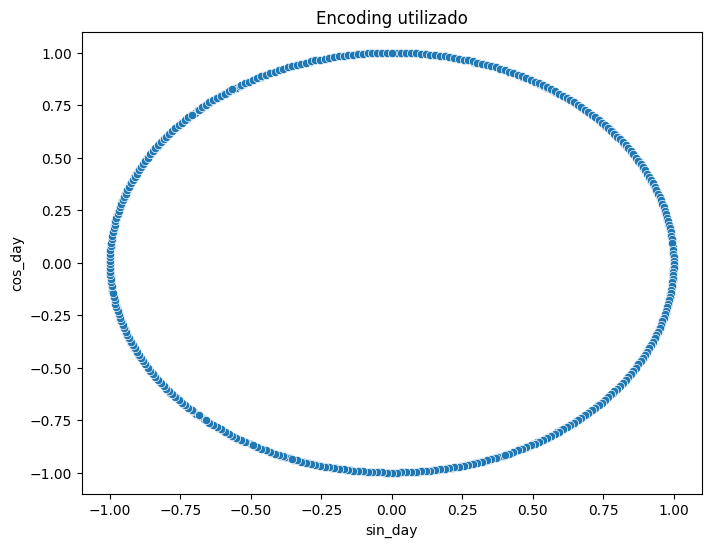

In [ ]:
fig = plt.figure(figsize=(8, 6))

sns.scatterplot(data=df_exp, x="sin_day", y="cos_day").set_title("Encoding utilizado")

plt.show()

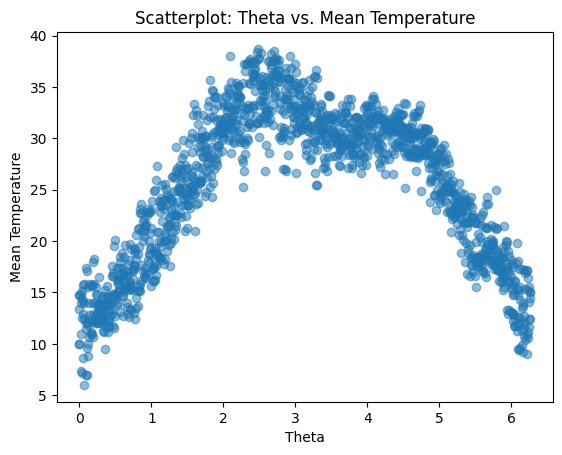

In [ ]:
plt.scatter(df_exp['theta'], df_exp['meantemp'], alpha=0.5)
plt.title('Scatterplot: Theta vs. Mean Temperature')
plt.xlabel('Theta')
plt.ylabel('Mean Temperature')
plt.show()

La gráfica obtenida con el ángulo theta tiene una forma similar a la de los meses, lo cual era de esperar pues ambas columnas representan un momento del año.  
  
### Finalmente  
  
Consideramos que no parece ser conveniente eliminar los *outliers* encontrados para la Presión promedio (meanpressure), dado que en este caso la red podría quedar demasiado sensible a cambios abruptos en estos valores. Pretenderemos dejarlos con la esperanza de que la red aprenda o entienda que para valores cercanos a la media se debe tomar en cuenta su variabilidad, mientras que para el caso contrario (valores exagerados) esto no deba suceder, o al menos no en un grado considerable. Como medida al respecto consideraremos usar el robust scaler para que los outlayers no influyan demasiado en posteriores pasos.
De momento solo organizaremos el conjunto train y test para que tengan las coumnas que usaremos para el entrenamiento.

In [ ]:
#testset
test_df['date'] = pd.to_datetime(test_df['date'])

test_df['day_of_year'] = test_df['date'].dt.dayofyear

theta = 2 * np.pi * (test_df['day_of_year'] - 1) / 365

test_df['sin_day'] = np.sin(theta)
test_df['cos_day'] = np.cos(theta)



#trainset
train_df['date'] = pd.to_datetime(train_df['date'])

train_df['day_of_year'] = train_df['date'].dt.dayofyear
train_df['year'] = train_df['date'].dt.year

train_df['theta'] = np.where(train_df['year'] == 2016,
                           2 * np.pi * (train_df['day_of_year'] - 1) / 366,
                           2 * np.pi * (train_df['day_of_year'] - 1) / 365)

train_df['sin_day'] = np.sin(train_df['theta'])
train_df['cos_day'] = np.cos(train_df['theta'])

In [ ]:
train_df

,date,meantemp,humidity,wind_speed,meanpressure,day_of_year,year,theta,sin_day,cos_day
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,2013,0.000000,0.000000,1.000000
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2,2013,0.017214,0.017213,0.999852
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,3,2013,0.034428,0.034422,0.999407
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,4,2013,0.051643,0.051620,0.998667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,5,2013,0.068857,0.068802,0.997630
...,...,...,...,...,...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,363,2016,6.214517,-0.068615,0.997643
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,364,2016,6.231684,-0.051479,0.998674
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,365,2016,6.248851,-0.034328,0.999411
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000,366,2016,6.266018,-0.017166,0.999853


In [ ]:
test_df

,date,meantemp,humidity,wind_speed,meanpressure,day_of_year,sin_day,cos_day
0,2017-01-01,15.913043,85.869565,2.743478,59.000000,1,0.000000,1.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778,2,0.017213,0.999852
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333,3,0.034422,0.999407
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000,4,0.051620,0.998667
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333,5,0.068802,0.997630
...,...,...,...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000,110,0.953681,-0.300820
110,2017-04-21,34.250000,39.375000,6.962500,999.875000,111,0.948362,-0.317191
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000,112,0.942761,-0.333469
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000,113,0.936881,-0.349647


In [ ]:
print(train_df.describe())

          meantemp     humidity   wind_speed  meanpressure  day_of_year  \
count  1462.000000  1462.000000  1462.000000   1462.000000  1462.000000   
mean     25.495521    60.771702     6.802209   1011.104548   183.000684   
std       7.348103    16.769652     4.561602    180.231668   105.546176   
min       6.000000    13.428571     0.000000     -3.041667     1.000000   
25%      18.857143    50.375000     3.475000   1001.580357    92.000000   
50%      27.714286    62.625000     6.221667   1008.563492   183.000000   
75%      31.305804    72.218750     9.238235   1014.944901   274.000000   
max      38.714286   100.000000    42.220000   7679.333333   366.000000   

              year        theta       sin_day      cos_day  
count  1462.000000  1462.000000  1.462000e+03  1462.000000  
mean   2014.502736     3.130848  9.720147e-18     0.000684  
std       1.120248     1.815642  7.071068e-01     0.707590  
min    2013.000000     0.000000 -9.999907e-01    -1.000000  
25%    2014.000000 

In [ ]:
print(test_df.describe())

         meantemp    humidity  wind_speed  meanpressure  day_of_year  \
count  114.000000  114.000000  114.000000    114.000000   114.000000   
mean    21.713079   56.258362    8.143924   1004.035090    57.500000   
std      6.360072   19.068083    3.588049     89.474692    33.052988   
min     11.000000   17.750000    1.387500     59.000000     1.000000   
25%     16.437198   39.625000    5.563542   1007.437500    29.250000   
50%     19.875000   57.750000    8.069444   1012.739316    57.500000   
75%     27.705357   71.902778   10.068750   1016.739583    85.750000   
max     34.500000   95.833333   19.314286   1022.809524   114.000000   

          sin_day     cos_day  
count  114.000000  114.000000  
mean     0.700003    0.477044  
std      0.311412    0.433528  
min      0.000000   -0.365723  
25%      0.467346    0.111656  
50%      0.826324    0.563130  
75%      0.969532    0.884043  
max      0.999991    1.000000  


### Escalamiento de los datos

In [ ]:
meanpressure = ['meanpressure']

robust_scaler = RobustScaler()
train_df[meanpressure] = robust_scaler.fit_transform(train_df[meanpressure])
test_df[meanpressure] = robust_scaler.transform(test_df[meanpressure])



humidity_wind_speed = ['humidity', 'wind_speed']

#standard
standard_scaler = StandardScaler()
#train_df[humidity_wind_speed] = standard_scaler.fit_transform(train_df[humidity_wind_speed])
#test_df[humidity_wind_speed] = standard_scaler.transform(test_df[humidity_wind_speed])

#minmax ----> FUNCIONA MEJOR QUE EL STANDARD
min_max_scaler = MinMaxScaler()
train_df[humidity_wind_speed] = min_max_scaler.fit_transform(train_df[humidity_wind_speed])
test_df[humidity_wind_speed] = min_max_scaler.transform(test_df[humidity_wind_speed])

In [ ]:
train_df

,date,meantemp,humidity,wind_speed,meanpressure,day_of_year,year,theta,sin_day,cos_day
0,2013-01-01,10.000000,0.820957,0.000000,0.531494,1,2013,0.000000,0.000000,1.000000
1,2013-01-02,7.400000,0.907591,0.070583,0.691120,2,2013,0.017214,0.017213,0.999852
2,2013-01-03,7.166667,0.849835,0.109743,0.755969,3,2013,0.034428,0.034422,0.999407
3,2013-01-04,8.666667,0.668867,0.029212,0.643731,4,2013,0.051643,0.051620,0.998667
4,2013-01-05,6.000000,0.847910,0.087636,0.593848,5,2013,0.068857,0.068802,0.997630
...,...,...,...,...,...,...,...,...,...,...
1457,2016-12-28,17.217391,0.630865,0.084032,0.523903,363,2016,6.214517,-0.068615,0.997643
1458,2016-12-29,15.238095,0.859736,0.142113,0.624134,364,2016,6.231684,-0.051479,0.998674
1459,2016-12-30,14.095238,0.880638,0.148429,0.698959,365,2016,6.248851,-0.034328,0.999411
1460,2016-12-31,15.052632,0.849835,0.173496,0.563918,366,2016,6.266018,-0.017166,0.999853


In [ ]:
print(train_df.describe())

          meantemp     humidity   wind_speed  meanpressure  day_of_year  \
count  1462.000000  1462.000000  1462.000000  1.462000e+03  1462.000000   
mean     25.495521     0.546868     0.161113  1.901341e-01   183.000684   
std       7.348103     0.193709     0.108044  1.348581e+01   105.546176   
min       6.000000     0.000000     0.000000 -7.569320e+01     1.000000   
25%      18.857143     0.426774     0.082307 -5.225120e-01    92.000000   
50%      27.714286     0.568276     0.147363  4.253325e-15   183.000000   
75%      31.305804     0.679094     0.218812  4.774880e-01   274.000000   
max      38.714286     1.000000     1.000000  4.991393e+02   366.000000   

              year        theta       sin_day      cos_day  
count  1462.000000  1462.000000  1.462000e+03  1462.000000  
mean   2014.502736     3.130848  9.720147e-18     0.000684  
std       1.120248     1.815642  7.071068e-01     0.707590  
min    2013.000000     0.000000 -9.999907e-01    -1.000000  
25%    2014.000000 

In [ ]:
print(test_df.describe())

         meantemp    humidity  wind_speed  meanpressure  day_of_year  \
count  114.000000  114.000000  114.000000    114.000000   114.000000   
mean    21.713079    0.494734    0.192893     -0.338837    57.500000   
std      6.360072    0.220258    0.084985      6.694930    33.052988   
min     11.000000    0.049917    0.032864    -71.050945     1.000000   
25%     16.437198    0.302599    0.131775     -0.084252    29.250000   
50%     19.875000    0.511964    0.191128      0.312455    57.500000   
75%     27.705357    0.675445    0.238483      0.611775    85.750000   
max     34.500000    0.951870    0.457468      1.065957   114.000000   

          sin_day     cos_day  
count  114.000000  114.000000  
mean     0.700003    0.477044  
std      0.311412    0.433528  
min      0.000000   -0.365723  
25%      0.467346    0.111656  
50%      0.826324    0.563130  
75%      0.969532    0.884043  
max      0.999991    1.000000  


## 2.3 Preprocesamiento

En esta seccion deberan aplicar las transformaciones necesarias a los datos para poder entrenar su modelo, crear columnas, eliminar columnas, escalar los datos, etc.

In [ ]:
objective_col = 'meantemp' # columna objetivo
selected_cols = ['humidity', 'wind_speed', 'meanpressure', 'sin_day', 'cos_day'] # lista de columnas seleccionadas para entrenar

In [ ]:
# IMPORTANTE: agregamos la columna objetivo al final de la lista, deben asegurarse de que este al final para el correcto funcionamiento del codigo
selected_cols.append(objective_col)
selected_cols

['humidity', 'wind_speed', 'meanpressure', 'sin_day', 'cos_day', 'meantemp']

In [ ]:
tr_timeseries = train_df[selected_cols].values.astype('float32')
te_timeseries = test_df[selected_cols].values.astype('float32')

In [ ]:
# concatenamos los dataframes para despues hacer las visualizaciones, No borrar ni modificar
new = pd.concat([train_df, test_df], axis=0).reset_index().drop('index', axis=1)
new_timeseries = new[selected_cols].values.astype('float32')
shape = new_timeseries.shape[1]

## 2.4 Dataset y DataLoader

In [ ]:
def create_dataset(dataset, lookback, shape):
    """Funcion para crear los tensores de entrenamiento y test
    dataset: np.ndarray
    lookback: int (numero de dias a considerar o largo de la secuencia)
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[:,:shape-1][i:i+lookback]
        target = dataset[:, shape-1][i:i+lookback]
        X.append(feature)
        y.append(target)
    # Convierte las listas a np.ndarray antes de convertirlas en tensores
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
lookback = 7 #consideraremos los ultimos 7 dias para predecir el dia siguiente

train, test = tr_timeseries, te_timeseries
X_train, y_train = create_dataset(train, lookback=lookback, shape=shape)
X_test, y_test = create_dataset(test, lookback=lookback, shape=shape)

In [ ]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size = 8, shuffle = True) #dataloader para entrenar los modelos de Pytorch

## 2.5 Modelo Recurrente

En esta seccion se implementa uan clase base para modelos recurrentes, pueden utilizar esta clase o pueden modificarla o crear una nueva clase si lo desean, recuerden que hay bonus por creatividad en esta tarea.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional, rnn_class):
        super().__init__()
        # Verificar que rnn_class es una de las clases de RNN permitidas
        if rnn_class not in [nn.LSTM, nn.GRU, nn.RNN]:
            raise ValueError("rnn_class must be nn.LSTM, nn.GRU, or nn.RNN")

        # Inicializar la capa recurrente con la clase pasada como parámetro
        self.rnn = rnn_class(input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=bidirectional)

        # Calcular la dimensión de salida de la capa recurrente
        # Es doble si es bidireccional
        factor = 2 if bidirectional else 1


        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(hidden_size * factor, 64)
        self.linear2 = nn.Linear(64, 32)
        self.output_linear = nn.Linear(32, 1)



    def forward(self, x):
        # LSTM devuelve (output, (h_n, c_n)) mientras que GRU y RNN solo devuelve (output, h_n)
        x, _ = self.rnn(x)


        x = self.dropout(x) # Aplicar dropout
        x = F.relu(self.linear1(x)) # Aplicar linear1
        x = F.relu(self.linear2(x)) # Aplicar linear2
        x = self.output_linear(x) # Aplicar output_linear


        return x

## 2.6 Hiperparámetros

Aca pueden variar los hiperparametros de la red recurrente, pueden agregar mas si lo desean, para mas informacion sobre los optimizadores pueden revisar la documentacion de [pytorch Optim](https://pytorch.org/docs/stable/optim.html), y para mas informacion sobre los criterios de perdida pueden revisar la documentacion de [pytorch Loss](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [ ]:
# Hiperparametros del modelo
input_size = shape-1


hidden_size = 64 #TODO
num_layers = 4 #TODO
dropout = 0.2 #TODO
bidirectional = True #puede ser True o False
layer_type = nn.RNN #puede ser nn.RNN, nn.LSTM o nn.GRU


# Modelo
model = RNNModel(input_size, hidden_size, num_layers, dropout, bidirectional, layer_type)


#optimizador
lr = 0.0001 #TODO
optimizer = torch.optim.AdamW(model.parameters(), lr=lr) #TODO

# loss func
loss_fn = nn.MSELoss() #TODO



## 2.7 Funciones de entrenamiento y evaluacion

En esta seccion se implementan funciones que nos ayudaran a entrenar y evaluar nuestro modelo, Pytorch no implementa metodos como .fit() por ende los tenemos que crear desde cero, al igual que antes sientanse libres de modificar o crear nuevas funciones, para mas informacion sobre el training loop pueden revisar la documentacion de [pytorch Custom Training](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#custom-training-loop)

In [ ]:
class CustomEarlyStopping:
    """
    Funcion para detener el entrenamiento cuando la loss de validacion no mejora
    """
    def __init__(self, patience=20, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
        self.best_y_pred = None

    def __call__(self, val_loss, model, X):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}, score: {self.best_score}')

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
            self.counter = 0

In [ ]:
def train_model(model, optimizer, early_stopping):
    """
    Funcion para entrenar el modelo
    """
    best_score = None
    best_weights = None

    n_epochs = 200

    for epoch in range(n_epochs):
        model.train() # Entrenamiento
        for X_batch, y_batch in loader:
            #MODIFICAR-MODIFICAR-MODIFICAR-MODIFICAR-MODIFICAR
            #MODIFICAR-MODIFICAR-MODIFICAR-MODIFICAR-MODIFICAR
            #MODIFICAR-MODIFICAR-MODIFICAR-MODIFICAR-MODIFICAR
            # Forward pass
            y_pred = model(X_batch)

            # Compute loss
            loss = loss_fn(y_pred, y_batch.unsqueeze(2))

            # Zero gradients
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()
            #MODIFICAR-MODIFICAR-MODIFICAR-MODIFICAR-MODIFICAR
            #MODIFICAR-MODIFICAR-MODIFICAR-MODIFICAR-MODIFICAR
            #MODIFICAR-MODIFICAR-MODIFICAR-MODIFICAR-MODIFICAR

        model.eval() # Validacion
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train.unsqueeze(2)))

            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test.unsqueeze(2)))

            if best_score is None or test_rmse < best_score:
                best_score = test_rmse
                best_weights = model.state_dict()

            early_stopping(test_rmse, model, X_test)

            # Check if early stopping criterion is met
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if epoch % 10 == 0:
            print('*'*10, 'Epoch: ', epoch, '\ train RMSE: ', train_rmse, '\ test RMSE', test_rmse)

    return model, best_weights

In [ ]:
def get_preds(model, best_weights):
    """
    Funcion para obtener las predicciones y desnormalizarlas
    """
    # Usamos los mejores pesos para hacer las predicciones
    if best_weights is not None:
        model.load_state_dict(best_weights)

        # Calculamos las predicciones
        with torch.no_grad():
            y_pred_train = model(X_train).clone().detach().cpu().numpy()
            y_pred_test = model(X_test).clone().detach().cpu().numpy()

        # Modificamos las dimensiones de las predicciones para luego graficarlas
        with torch.no_grad():
            train_predictions = np.ones_like(new_timeseries) * np.nan
            train_predictions[lookback: len(train)] = y_pred_train[:,-1,:]

            test_predictions = np.ones_like(new_timeseries) * np.nan
            test_predictions[len(train)+lookback:len(new_timeseries)] = y_pred_test[:,-1,:]

        return train_predictions, test_predictions

In [ ]:
def plot_predictions(train_predictions, test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """
    # plot
    plt.figure(figsize=(20,10))
    plt.plot(new_timeseries[:,shape-1], c = 'b', label = 'True')
    plt.plot(train_predictions[:,shape-1], c='r', label = 'Train')
    plt.plot(test_predictions[:,shape-1], c='g', label = 'Test')
    plt.legend()
    plt.show()

In [ ]:
def plot_eval(test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """

    eval_df = pd.concat([test_df['meantemp'].reset_index(),pd.Series(test_predictions[:,shape-1][len(train):].reshape(-1).tolist())],axis=1).drop('index',axis=1) #creamos un dataframe con las predicciones y los valores reales

    eval_df.columns = ['real_meantemp', 'pred_meantemp'] #renombramos las columnas

    rmse = np.sqrt(mean_squared_error(eval_df.iloc[7:]['real_meantemp'], eval_df.iloc[7:]['pred_meantemp'])) #calculamos el rmse

    print(f'RMSE: {rmse}')

    fig = go.Figure(data = [
        go.Scatter(x = eval_df.index, y = eval_df['real_meantemp'], mode='lines', name = "Actual"),
        go.Scatter(x = eval_df.index, y = eval_df['pred_meantemp'], mode='lines', name="Predicted"),
    ])

    fig.update_layout(
        font = dict(size=17, family="Franklin Gothic"),
        template = 'simple_white',
        title = 'Real & Predicted Temperature'
    )

    fig.show()

## 2.8 Entrenamiento

In [ ]:
early_stopping = CustomEarlyStopping(patience=15, verbose=True)
model, model_best_weights = train_model(model, optimizer, early_stopping)

********** Epoch:  0 \ train RMSE:  tensor(20.4016) \ test RMSE tensor(16.0944)
EarlyStopping counter: 1 out of 15, score: -6.132694721221924
EarlyStopping counter: 2 out of 15, score: -6.132694721221924
EarlyStopping counter: 3 out of 15, score: -6.132694721221924
EarlyStopping counter: 4 out of 15, score: -6.132694721221924
EarlyStopping counter: 1 out of 15, score: -2.412114381790161
EarlyStopping counter: 2 out of 15, score: -2.412114381790161
********** Epoch:  10 \ train RMSE:  tensor(2.4304) \ test RMSE tensor(2.4414)
EarlyStopping counter: 3 out of 15, score: -2.412114381790161
EarlyStopping counter: 4 out of 15, score: -2.412114381790161
EarlyStopping counter: 5 out of 15, score: -2.412114381790161
EarlyStopping counter: 6 out of 15, score: -2.412114381790161
EarlyStopping counter: 1 out of 15, score: -2.3836591243743896
EarlyStopping counter: 2 out of 15, score: -2.3836591243743896
EarlyStopping counter: 3 out of 15, score: -2.3836591243743896
EarlyStopping counter: 4 out of 

In [ ]:
train_predictions, test_predictions = get_preds(model, model_best_weights)

## 2.9 Evaluacion ayudante (NO CORRER)

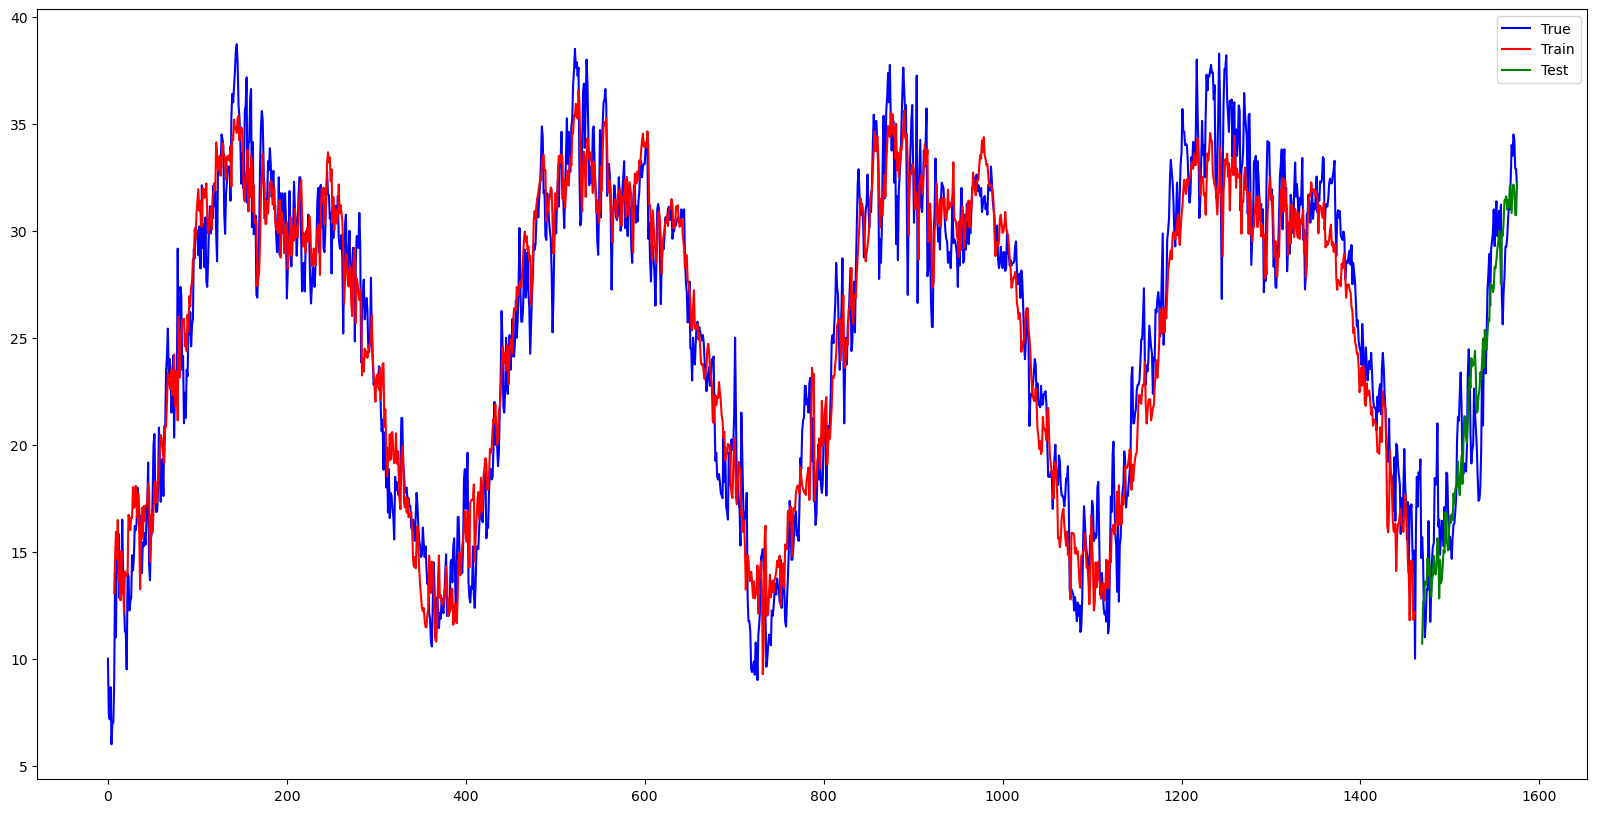

In [ ]:
plot_predictions(train_predictions, test_predictions)

In [ ]:
plot_eval(test_predictions)

RMSE: 2.504925946161387


# Nuestra evaluación

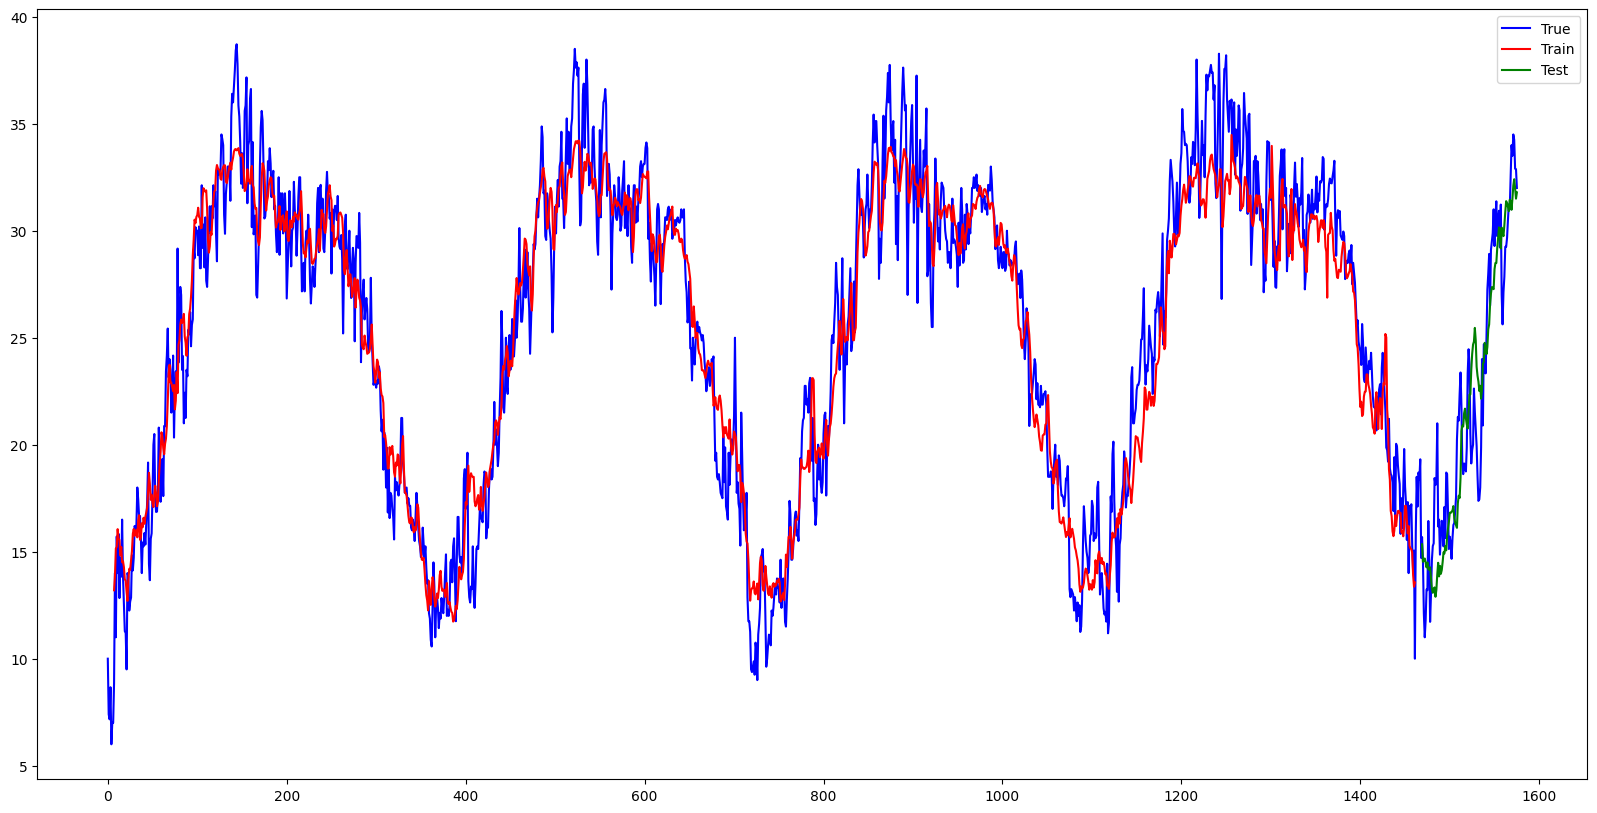

In [ ]:
plot_predictions(train_predictions, test_predictions, shape)

In [ ]:
plot_eval(test_predictions, shape)

RMSE: 2.6868921458442467


# Parte 3: Transformers

Para esta parte vamos a entrenar un transformer muy simple para que aprenda a generar texto como el del Quijote.

### 3.1 Cargar el dataset

In [ ]:
#ss
#data_path = "/content/drive/MyDrive/Colab Notebooks/tarea3/data/el_quijote.txt"

#js
data_path = "/content/drive/MyDrive/Tarea 3 INF 395/data/el_quijote.txt"

with open(data_path, 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
# (enunciado, no correr)
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1038397


In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1038397


In [ ]:
# Visualizamos los primeros 1000 caracteres (pauta)
print(text[:1000])

DON QUIJOTE DE LA MANCHA
Miguel de Cervantes Saavedra

PRIMERA PARTE
CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años, era de complexión recia, sec

In [ ]:
print(text[:1000])

DON QUIJOTE DE LA MANCHA
Miguel de Cervantes Saavedra

PRIMERA PARTE
CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años, era de complexión recia, sec

### 3.2 Preprocesar el dataset

Vamos a crear un tokenizador muy simple que convierta el texto en una secuencia de números.

In [ ]:
# Enunciado (no correr!)

chars = #TODO #obtener los caracteres unicos del texto
vocab_size = len(chars)
print('Caracteres unicos:',''.join(chars))
print('Largo del vocabulario:',vocab_size)

Caracteres unicos: 
 !"'(),-.0123456789:;<?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijlmnopqrstuvxyz¡«»¿̀́̃̈–‘’“”
Largo del vocabulario: 89


In [ ]:
# Propio (final)

# Obtaining unique characters from the text
chars = list(set(text))

# Removing whitespace characters
chars = [char for char in chars]
# Sorting the characters for better readability
chars.sort()

vocab_size = len(chars)

print('Caracteres unicos:', ''.join(chars))
print('Largo del vocabulario:', vocab_size)

Caracteres unicos: 
 !"'(),-.0123456789:;<?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijlmnopqrstuvxyz¡«»¿̀́̃̈–‘’“”
Largo del vocabulario: 89


### 3.3 Encoding y Decoding

Ahora que tenemos el tokenizador, vamos a crear una función que nos permita convertir el texto en una secuencia de números y viceversa.

In [ ]:
# Enunciado: no correr!

# Mapeamos cada caracter a un entero
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: toma un string, devuelve una lista de enteros
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: toma una lista de enteros, devuelve un string

print(encode("Quijote de la Mancha"))
print(decode(encode("Quijote de la Mancha")))

[40, 71, 60, 61, 65, 70, 56, 1, 55, 56, 1, 62, 52, 1, 36, 52, 64, 54, 59, 52]
Quijote de la Mancha


In [ ]:
# Propio (final)

# Mapeamos cada caracter a un entero
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: toma un string, devuelve una lista de enteros
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: toma una lista de enteros, devuelve un string

print(encode("Quijote de la Mancha"))
print(decode(encode("Quijote de la Mancha")))

[40, 71, 60, 61, 65, 70, 56, 1, 55, 56, 1, 62, 52, 1, 36, 52, 64, 54, 59, 52]
Quijote de la Mancha


**Pregunta: Que otros tipos de tokenizaciones ademas de por caracteres existen y cuales serian las ventajas?**  
**Respuesta:**  

*   *Tokenización por Palabras*: Útil para tareas que dependen del significado de las palabras, reduce la dimensionalidad del texto en comparación con la tokenización de caracteres y puede manejar mejor el sentido semántico en algunos casos.

*   *Tokenización por Subpalabras*: Útil para tratar con palabras fuera del vocabulario común, puede manejar eficientemente palabras compuestas o idiomas con una gran variabilidad morfológica y ayuda a abordar el problema de la rareza en vocabularios grandes.  

*   *Tokenización por Frases*: Útil cuando la unidad de procesamiento es una oración completa y puede ser beneficioso para tareas de traducción automática y resumen de texto.  

*   *Tokenización por Caracteres gramaticales*: Útil para conservar información gramatical, como prefijos y sufijos, además puede ser beneficioso en tareas que implican el análisis morfológico.  

*   *Tokenización por Expresiones Regulares*: Ofrece flexibilidad para definir patrones de tokenización y puede adaptarse a requisitos específicos del dominio.  

*   *Tokenización por Líneas*: Útil cuando el texto está organizado en líneas y cada línea es una unidad de procesamiento independiente.  

*   *Tokenización por Palabras Clave*: Útil para extraer términos clave o entidades específicas.  

*   *Tokenización por N-gramas*: Conserva la información sobre secuencias de palabras y puede ser útil en tareas de modelado de lenguaje.  

*   *Tokenización por Párrafos*: Útil si la unidad de procesamiento es un párrafo completo.  

*   *Tokenización por Símbolos*: Útil para idiomas que no tienen una separación clara entre palabras.





**Pregunta: ¿que otras tecnicas se utilizan antes de tokenizar en problemas de NLP?**

**Respuesta:**  
*   *Limpieza*: Dependiendo del contexto del problema en sí y de los objetivos que se tienen, puede ser válido eliminar ciertos caracteres como números, de puntuación, símbolos, emojis o incluso palabras completas del texto fuente.
*   *Stemming*: Una misma palabra se puede encontrar de diferentes formas dependiendo del género, del número, la persona, etc. El stemming por lo general designa el simple proceso heurístico de cortar el final de las palabras para mantener solo la raíz de la palabra. Por ejemplo: encontrarás -> encontr  
*   *Lematización*: Similar al stemming pero utilizando un vocabulario y un análisis minucioso de la construcción de las palabras. La lematización permite eliminar únicamente las terminaciones inflexibles y de ese modo aislar la forma canónica de la palabra, conocida como lema. Ejemplo: encontrarás -> encontrar
*   *Cambio a minúsculas*
*   *Corrección de Errores Ortográficos*: Dependiendo de la calidad de los datos, puede ser útil corregir errores ortográficos para mejorar la coherencia y la precisión del modelo.
*   *Manejo de Etiquetas HTML y Caracteres Especiales*: En textos provenientes de páginas web, es común encontrar etiquetas HTML y caracteres especiales que deben ser eliminados o manejados de manera adecuada.

### 3.4 Train y Val Split

In [ ]:
# Enunciado: No correr!

# Vamos a Codificar el texto y llevarlo a un tensor de Pytorch
data = torch.tensor(encode(text), dtype=torch.long)

# Separamos en train y validation
n = #TODO # % de los datos para entrenar
train_data = data[:n]
val_data = data[n:]

print(train_data.shape, train_data.dtype)
print(train_data[:1000]) # los primeros 1000 caracteres del texto codificado

torch.Size([934557]) torch.int64
tensor([27, 38, 37,  1, 40, 44, 32, 33, 38, 43, 28,  1, 27, 28,  1, 35, 24,  1,
        36, 24, 37, 26, 31, 24,  0, 36, 60, 58, 71, 56, 62,  1, 55, 56,  1, 26,
        56, 68, 72, 52, 64, 70, 56, 69,  1, 42, 52, 52, 72, 56, 55, 68, 52,  0,
         0, 39, 41, 32, 36, 28, 41, 24,  1, 39, 24, 41, 43, 28,  0, 26, 24, 39,
        32, 81, 43, 44, 35, 38,  1, 11, 20,  1, 40, 71, 56,  1, 70, 68, 52, 70,
        52,  1, 55, 56,  1, 62, 52,  1, 54, 65, 64, 55, 60, 54, 60, 65, 81, 64,
         1, 74,  1, 56, 61, 56, 68, 54, 60, 54, 60, 65,  1, 55, 56, 62,  1, 57,
        52, 63, 65, 69, 65,  1, 59, 60, 55, 52, 62, 58, 65,  1, 27,  9,  1, 40,
        71, 60, 61, 65, 70, 56,  1, 55, 56,  1, 62, 52,  1, 36, 52, 64, 54, 59,
        52,  0, 28, 64,  1, 71, 64,  1, 62, 71, 58, 52, 68,  1, 55, 56,  1, 62,
        52,  1, 36, 52, 64, 54, 59, 52,  7,  1, 55, 56,  1, 54, 71, 74, 65,  1,
        64, 65, 63, 53, 68, 56,  1, 64, 65,  1, 67, 71, 60, 56, 68, 65,  1, 52,
       

In [ ]:
# Propio (final)

# Vamos a Codificar el texto y llevarlo a un tensor de Pytorch
data = torch.tensor(encode(text), dtype=torch.long)

# Separamos en train y validation
n = 934557 # 90% de los datos para entrenar
train_data = data[:n]
val_data = data[n:]

print(train_data.shape, train_data.dtype)
print(train_data[:1000]) # los primeros 1000 caracteres del texto codificado

torch.Size([934557]) torch.int64
tensor([27, 38, 37,  1, 40, 44, 32, 33, 38, 43, 28,  1, 27, 28,  1, 35, 24,  1,
        36, 24, 37, 26, 31, 24,  0, 36, 60, 58, 71, 56, 62,  1, 55, 56,  1, 26,
        56, 68, 72, 52, 64, 70, 56, 69,  1, 42, 52, 52, 72, 56, 55, 68, 52,  0,
         0, 39, 41, 32, 36, 28, 41, 24,  1, 39, 24, 41, 43, 28,  0, 26, 24, 39,
        32, 81, 43, 44, 35, 38,  1, 11, 20,  1, 40, 71, 56,  1, 70, 68, 52, 70,
        52,  1, 55, 56,  1, 62, 52,  1, 54, 65, 64, 55, 60, 54, 60, 65, 81, 64,
         1, 74,  1, 56, 61, 56, 68, 54, 60, 54, 60, 65,  1, 55, 56, 62,  1, 57,
        52, 63, 65, 69, 65,  1, 59, 60, 55, 52, 62, 58, 65,  1, 27,  9,  1, 40,
        71, 60, 61, 65, 70, 56,  1, 55, 56,  1, 62, 52,  1, 36, 52, 64, 54, 59,
        52,  0, 28, 64,  1, 71, 64,  1, 62, 71, 58, 52, 68,  1, 55, 56,  1, 62,
        52,  1, 36, 52, 64, 54, 59, 52,  7,  1, 55, 56,  1, 54, 71, 74, 65,  1,
        64, 65, 63, 53, 68, 56,  1, 64, 65,  1, 67, 71, 60, 56, 68, 65,  1, 52,
       

### 3.5 Generando sequencias de texto

El transformer es una arquitectura de secuencias, por lo que necesitamos generar las secuencias de texto que vamos a utilizar para entrenar el modelo.

In [ ]:
batch_size = 4 # cuantas secuencias de texto vamos a procesar en paralelo
block_size = 8 # definimos el largo de nuestra sequencia

def get_batch(split):
    # generamos un batch de datos
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [ ]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"cuando el input es {context} el target es: {target}")

inputs:
torch.Size([4, 8])
tensor([[64, 69, 70, 52, 64, 70, 60, 64],
        [68, 70, 65, 21,  1, 67, 71, 56],
        [52, 68, 54, 52,  1, 62, 65, 69],
        [62, 65, 69,  1, 66, 65, 68,  1]])
targets:
torch.Size([4, 8])
tensor([[69, 70, 52, 64, 70, 60, 64, 65],
        [70, 65, 21,  1, 67, 71, 56,  1],
        [68, 54, 52,  1, 62, 65, 69,  1],
        [65, 69,  1, 66, 65, 68,  1, 62]])
----
cuando el input es tensor([64]) el target es: 69
cuando el input es tensor([64, 69]) el target es: 70
cuando el input es tensor([64, 69, 70]) el target es: 52
cuando el input es tensor([64, 69, 70, 52]) el target es: 64
cuando el input es tensor([64, 69, 70, 52, 64]) el target es: 70
cuando el input es tensor([64, 69, 70, 52, 64, 70]) el target es: 60
cuando el input es tensor([64, 69, 70, 52, 64, 70, 60]) el target es: 64
cuando el input es tensor([64, 69, 70, 52, 64, 70, 60, 64]) el target es: 65
cuando el input es tensor([68]) el target es: 70
cuando el input es tensor([68, 70]) el target es:

### 3.6 Creando el modelo

Vamos a crear un modelo naive que consiste en una capa de embedding, y una capa de salida que predice la siguiente palabra

In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # cada token se representa como un vector de vocab_size dimensiones
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx y targets son (B, T) arrays de indices en el vocabulario
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

**Pregunta: Explique que hace la funcion Generate (indicar que hace cada linea de la funcion)**

In [ ]:
# Hiperparametros
naive_model = BigramLanguageModel(vocab_size)
optimizer = #TODO
batch_size = #TODO
epochs = #TODO

In [ ]:
# Hiperparametros
naive_model = BigramLanguageModel(vocab_size)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=0.001)
batch_size = 32
epochs = 100

En esta seccion deberan crear un loop de entrenamiento para esto pueden revisar la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [ ]:
# Entrenamiento
for i in range(epochs):
    # obtenemos un batch de datos
    #TODO

    # Obtenemos las predicciones del modelo y la loss
    #TODO

    # reseteamos el gradiente
    #TODO

    # Backward Pass
    #TODO

    # Actualizamos los pesos
    #TODO

    # Visualizamos el resultado cada 10 iteraciones
    if i % 10 == 0:
        print(f"Epoch {i} | Loss {loss.item():.4f}")

Epoch 0 | Loss 5.0353
Epoch 10 | Loss 5.0066
Epoch 20 | Loss 4.9951
Epoch 30 | Loss 4.9283
Epoch 40 | Loss 4.9283
Epoch 50 | Loss 5.0092
Epoch 60 | Loss 4.8959
Epoch 70 | Loss 4.8777
Epoch 80 | Loss 4.8310
Epoch 90 | Loss 4.9345


In [ ]:
# Entrenamiento
for i in range(epochs):
    # Obtenemos un batch de datos
    inputs, targets = get_batch('train')

    # Obtenemos las predicciones del modelo y la loss
    logits, loss = naive_model(inputs, targets)

    # Reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optimizer.step()

    # Visualizamos el resultado cada 10 iteraciones
    if i % 10 == 0:
        print(f"Epoch {i} | Loss {loss.item():.4f}")

Epoch 0 | Loss 4.9384
Epoch 10 | Loss 5.0089
Epoch 20 | Loss 4.9408
Epoch 30 | Loss 4.9396
Epoch 40 | Loss 4.9110
Epoch 50 | Loss 4.8097
Epoch 60 | Loss 4.8663
Epoch 70 | Loss 4.9056
Epoch 80 | Loss 4.8646
Epoch 90 | Loss 4.8661


In [ ]:
# Enunciado (no correr!)
print('loss:', loss.item())
print(decode(naive_model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

loss: 4.777909278869629

8s4““,T[W»6'e(u¿T¡hvM<z?WZzEB̀XRqBiMV¿»n,;OTśt‘I“<GKz,fV[o<i-uoH8«‘“"”
–zEḦ[XI(Asx‘H3BHJVbTA»Rv«»0


In [ ]:
# Propio
print('loss:', loss.item())
print(decode(naive_model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

loss: 4.778235912322998

8’)»-n9
D0Ae
eyQ¡mdxQpnM?̀́)‘8TPK<]Bhjmps:“mCìgzJ6K(G;0”IoQGzmC(l’W"2p0ldd«”
Ar0MG0xhtY0bMHB'!̀pM0K


Como vemos el modelo no es capaaz de generar texto coherente, para esto vamos a utilizar un transformer.

### 3.7 Transformer

El transformer es una arquitectura de secuencias que utiliza atención para poder capturar dependencias de largo plazo, en esta seccion deberan completar las lineas de codigo faltantes, para esto pueden revisar el paper originar [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) y la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [ ]:
n_embd = #TODO # dimension de los embeddings
n_head = #TODO # numero de cabezas de atencion
n_layer = #TODO # numero de capas
dropout = #TODO # dropout

In [ ]:
# Hyperparameters for a Transformer model
n_embd = 256  # Adjust the dimension of the embeddings based on your requirements
n_head = 8    # Adjust the number of attention heads
n_layer = 6   # Adjust the number of layers
dropout = 0.1 # Adjust the dropout rate as needed

In [ ]:
class Head(nn.Module):
    """ cabezal de auto-atencion """

    def __init__(self, head_size):
        super().__init__()
        self.key = #TODO
        self.query = #TODO
        self.value = #TODO
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = #TODO

    def forward(self, x):
        B,T,C = x.shape
        k = #TODO
        q = #TODO

        # Calcula la matriz de pesos (Afinidades)
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        softmax = #TODO
        dropout = #TODO

        # Calcula la ponderacion de los valores por los pesos atencionales
        v = #TODO
        out = #TODO


        return out

In [ ]:
class Head(nn.Module):
    """Cabezal de auto-atencion"""

    def __init__(self, head_size):
        super().__init__()

        # Weight matrices for key, query, and value
        self.key = nn.Linear(head_size, head_size)
        self.query = nn.Linear(head_size, head_size)
        self.value = nn.Linear(head_size, head_size)

        # Lower triangular matrix for masking
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        # Dropout layer
        self.dropout = nn.Dropout(0.1)  # You can adjust the dropout rate as needed

    def forward(self, x):
        B, T, C = x.shape

        # Linear transformations for key, query, and value
        k = self.key(x)
        q = self.query(x)

        # Calculate the attention weights matrix (Affinities)
        wei = q @ k.transpose(-2, -1) * (C ** -0.5)  # (B, T, C) @ (B, C, T) -> (B, T, T)

        # Masking the lower triangular part
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)

        # Softmax and dropout
        softmax = F.softmax(wei, dim=-1)
        dropout = self.dropout(softmax)

        # Weighted sum of values
        v = self.value(x)
        out = dropout @ v  # (B, T, T) @ (B, T, C) -> (B, T, C)

        return out

**Pregunta: En sus propias palabras explique como funciona el mecanismo de auto-atencion**  
**Respuesta:**  
 El mecanismo de autoatención permite al modelo asignar diferentes pesos de atención a diferentes partes de la entrada en función de la similitud entre las consultas y las claves. Esto facilita la captura de relaciones a larga distancia y la identificación de patrones importantes en la entrada. La máscara triangular asegura que durante el entrenamiento, la autoatención solo se base en información previa en la secuencia.

In [ ]:
class MultiHeadAttention(nn.Module):
    """ Multiples cabezales de auto-atencion """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [ ]:
class FeedFoward(nn.Module):
    """ Capa FeedForward """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            #TODO
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# Propio

class FeedForward(nn.Module):
    """Capa FeedForward"""

    def __init__(self, n_embd):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # You can adjust the hidden layer size as needed
            nn.ReLU(),                      # Activation function (e.g., ReLU)
            nn.Linear(4 * n_embd, n_embd),  # You can adjust the hidden layer size as needed
            nn.Dropout(0.1)                 # You can adjust the dropout rate as needed
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Block(nn.Module):
    """ Bloque de Transformer """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

**Pregunta: Que parte del transformer estamos implementando?**  
**Respuesta:**  
Consiste en una capa de autoatención seguida por una capa de alimentación hacia adelante, con capas de normalización aplicadas antes y después de cada subcapa para mejorar la estabilidad del entrenamiento

In [ ]:
# Ahora definimos el modelo completo con los bloques de Transformer
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

**Bonus: Desde que salio el transformer se han publicado mejoras para esta arquitectura, si implementan alguna mejora con la referencia del paper en cuestion obtendran un bonus, se atreven?**

In [ ]:
model = BigramLanguageModel()
m = model.to(device)

# Parametros del modelo
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Hiperparametros
lr = #TODO
optimizer = #TODO
epochs = #TODO
eval_interval = 100
eval_iters = 200

0.211289 M parameters


In [ ]:
# Funcion de evaluar el modelo
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
for i in range(epochs):
    # cada 100 iteraciones evaluamos el modelo
    if i % eval_interval == 0 or i == epochs - 1:
        losses = estimate_loss()
        print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Obtenemos un batch de datos
    #TODO

    # Obtener las predicciones del modelo y la loss
    #TODO

    # reseteamos el gradiente
    #TODO

    # Backward Pass
    #TODO

    # Actualizamos los pesos
    #TODO

step 0: train loss 4.5656, val loss 4.5581
step 100: train loss 2.3226, val loss 2.3630
step 200: train loss 2.1939, val loss 2.2362
step 300: train loss 2.1426, val loss 2.1732
step 400: train loss 2.0930, val loss 2.1207
step 500: train loss 2.0594, val loss 2.0937
step 600: train loss 2.0310, val loss 2.0840
step 700: train loss 2.0017, val loss 2.0517
step 800: train loss 1.9931, val loss 2.0361
step 900: train loss 1.9708, val loss 2.0186
step 1000: train loss 1.9661, val loss 2.0071
step 1100: train loss 1.9362, val loss 2.0007
step 1200: train loss 1.9218, val loss 1.9768
step 1300: train loss 1.9131, val loss 1.9669
step 1400: train loss 1.9024, val loss 1.9679
step 1500: train loss 1.8789, val loss 1.9642
step 1600: train loss 1.8753, val loss 1.9206
step 1700: train loss 1.8685, val loss 1.9226
step 1800: train loss 1.8750, val loss 1.9409
step 1900: train loss 1.8556, val loss 1.9041
step 2000: train loss 1.8537, val loss 1.9055
step 2100: train loss 1.8392, val loss 1.9003


In [ ]:
# Generamos las predicciones
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


Eleil brados abía, éstaba acirdumas de me su pestí su que se ni pues, al forde una lariencabal curo; y alí se valvade que aalgántilo"
-Nespondió de su mandado de la recida. Perotres sagraso, y porque al los vida en el ningón con el las ha galar enfamala razon y las punto de acaseravan que respareo no de casas,tora de dé duda sin,  fue hasto de apenaba por todos Dioso Esten cama le soltión, y padros nos vuestro que sillestro y ellar de haced que que pe dijo Recho cual entura y la otras y Zoraño adelligatir due a barpes corrás as encamigarosu el malgas casilla osufa;, si comelsar compenio, y aún luello, a tantodo mate aun eruente, dondespecha elles niención mazo, selevatendo cierda; y tinienced mala ibonse de lo hecermas, las raza volvente por que él hubiero tierna, inteñoreso despeseju acomola dijo por adren del rálipa permadar El me las cuitros casasn de cuallabo señora, por ahedo dan tomanar alecigo, y estro; o su adía, venía quede ser engu, la sianque siemigeza, y

Ahora las predicciones ya tienen un poco de sentido, podemos seguir entrenando el modelo para que genere texto más coherente y pueden utilizar el modelo cambiando el archivo de input para generar texto de otros libros o de lo que ustedes quieran.

# Bonus: Armonic Oscillator (PINN)

## Simular un oscilador armónico

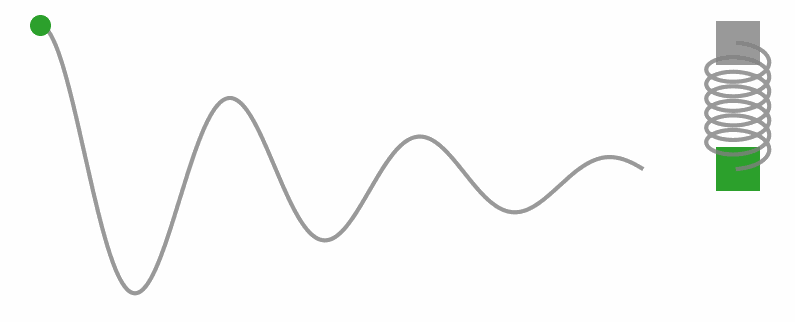

Vamos a utilizar una red neuronal con física incorporada (PINN por sus siglas en inglés) para resolver problemas relacionados con el **oscilador armónico amortiguado**:

Nos interesa modelar el desplazamiento de la masa en un resorte (caja verde) a lo largo del tiempo.

Este es un problema canónico de la física, donde el desplazamiento, $u(t)$, del oscilador como función del tiempo puede ser descrito por la siguiente ecuación diferencial:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

donde $ m $ es la masa del oscilador, $ \mu $ es el coeficiente de fricción y $ k $ es la constante del resorte.

Nos centraremos en resolver el problema en el estado **subamortiguado**, es decir, donde la oscilación es lentamente amortiguada por la fricción (como se muestra en la animación arriba).

Matemáticamente, esto ocurre cuando:

$$
\delta < \omega_0~,~~~~~\mathrm{donde}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Además, consideramos las siguientes condiciones iniciales del sistema:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

Para este caso particular, la solución exacta es conocida y dada por:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{con}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$


### Definimos nuestra Red Neuronal

In [ ]:
class simple_ffn(nn.Module):
    "Definimos una red neuronal feed forward en PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.input = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.hidden = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.output = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        return x

*Pregunta: ¿Porque se utiliza Tanh como función de activación generalmente en las PINNs?*

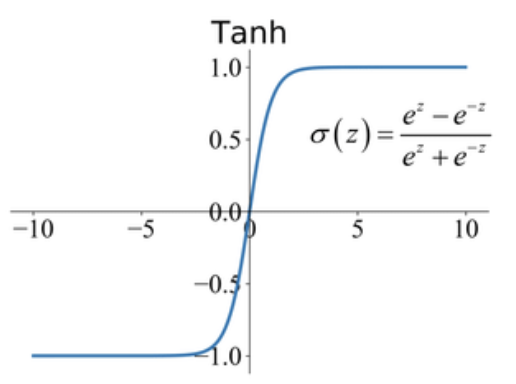

Tanh se usa como función de activación usualmente en  Redes Neuronales Informadas por Física (PINNs, por sus siglas en inglés) por lo siguiente:

Simetría y Rango: La función tanh es simétrica alrededor del origen (0,0), lo cual significa que produce valores en el rango de [-1, 1]. Esta simetría puede ser ventajosa para las redes neuronales porque ayuda a centrar las activaciones y asegura que la salida de la red no esté sesgada hacia valores positivos o negativos. En contraste, otras funciones de activación como la función sigmoide no son simétricas y pueden dar lugar a gradientes que tienden a desaparecer para valores extremos de entrada.

Efecto de Compresión: Al igual que la función sigmoide, tanh "comprime" los valores de entrada a un cierto rango, reduciéndolos a un intervalo acotado. Esto puede ser beneficioso para la estabilidad numérica del proceso de entrenamiento, especialmente al trabajar con redes profundas y retropropagación a través de muchas capas.

Suavidad: La función tanh es diferenciable en todo punto, lo cual es crucial para los métodos de optimización basados en gradientes utilizados durante el entrenamiento de las redes neuronales. Funciones de activación suaves ayudan en el flujo de gradientes y contribuyen a un entrenamiento estable.


Precedente Histórico: Tanh ha sido ampliamente utilizado en arquitecturas tradicionales de redes neuronales, y su adopción en PINNs puede estar influenciada por el éxito de tanh en aplicaciones anteriores. Aunque otras funciones de activación como la unidad lineal rectificada (ReLU) han ganado popularidad en algunos dominios, tanh sigue siendo una elección común, especialmente cuando se trata de imponer propiedades o restricciones específicas en la red.

Centrado de Datos: Al mapear las entradas al rango de [-1, 1], tanh ayuda a centrar los datos alrededor de cero. Esto puede ser útil en ciertas situaciones, especialmente al tratar problemas informados por física donde el comportamiento del sistema podría tener una naturaleza simétrica o equilibrada.

Es importante señalar que la elección de la función de activación, incluida tanh, puede depender de las características específicas del problema en cuestión y de las preferencias del diseñador del modelo. En algunos casos, los investigadores pueden experimentar con diferentes funciones de activación para ver cuál funciona mejor para una aplicación particular.

###  Solucion Exacta

In [ ]:
def exact_solution(d, w0, t):
    "Define la solucion analitica del problema planteado"
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

### Puntos de entrenamiento

In [ ]:
# Definimos los puntos para la condicion de borde
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# Definimos los puntos del dominio del problema
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# parametros del problema
d, w0 = 2, 20
mu, k = 2*d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

### Hiperparámetros y Modelo

In [ ]:
epochs = 15001
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optim = torch.optim.Adam(pinn.parameters(),lr=1e-3)
lambda1, lambda2 = 1e-1, 1e-4

### Entrenamiento

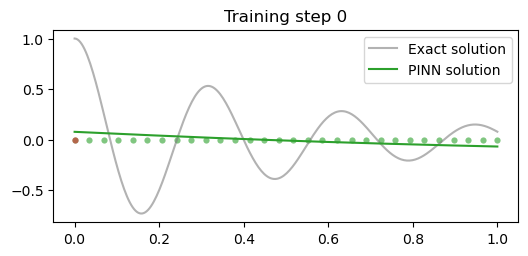

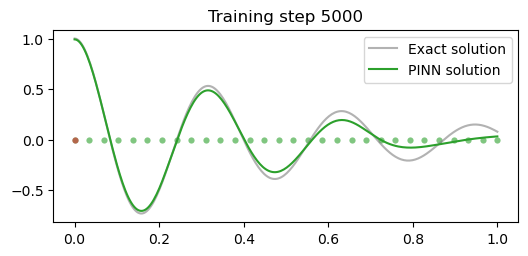

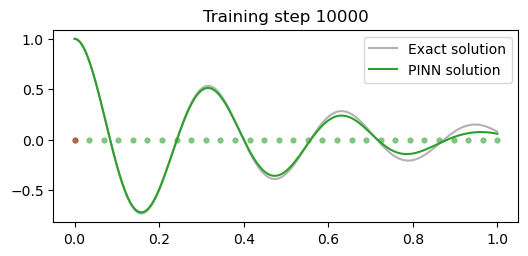

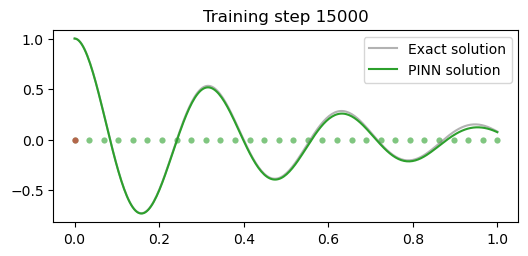

In [ ]:
# PAUTA NO CORRER!
for i in range(15001):
    optim.zero_grad() # reseteamos el gradiente

    # Calculamos la perdida de la condicion de borde
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    loss2 = (torch.squeeze(dudt) - 0)**2

    # Calculamos la perdida de la ecuacion diferencial
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0] # calculamos la segunda derivada
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2 + lambda2*loss3

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optim.step()

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

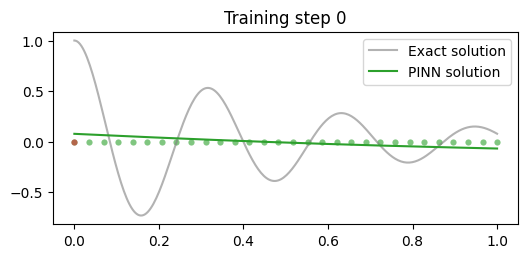

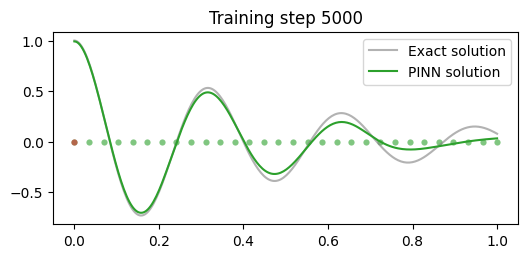

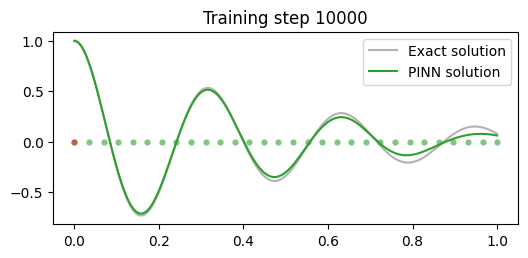

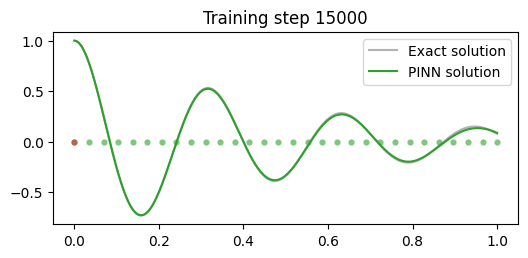

In [ ]:
for i in range(15001):
    optim.zero_grad() # reseteamos el gradiente

    # Calculamos la perdida de la condicion de borde
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    loss2 = (torch.squeeze(dudt) - 0)**2

    # Calculamos la perdida de la ecuacion diferencial
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0] # calculamos la segunda derivada
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2 + lambda2*loss3

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optim.step()

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

## entrenar una PINN para invertir los parámetros subyacentes

La segunda tarea consiste en usar una PINN para **Estimar** parámetros.

Específicamente, nuestras entradas y salidas son:

- Entradas: observaciones con ruido del desplazamiento del oscilador
- Salidas: estimar $\mu$, el coeficiente de fricción

#### Enfoque

De manera similar a lo anterior, la PINN se entrena para aproximar directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

donde $\theta$ son los parámetros libres de la PINN.

La idea clave aquí es también tratar $\mu$ como un **parámetro aprendible** al entrenar la PINN, de modo que simulamos la solución e invertimos para este parámetro.

#### Función de pérdida

La PINN se entrena con una función de pérdida ligeramente diferente:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( u_{\mathrm{PINN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

#### Notas

Hay dos términos en la función de pérdida aquí. El primero es la **pérdida física**, formada de la misma manera que arriba, que asegura que la solución aprendida por la PINN es consistente con la física conocida.

El segundo término se llama **pérdida de datos**, y asegura que la solución aprendida por la PINN se ajuste a las observaciones de la solución (potencialmente con ruido) que están disponibles.

Nota, hemos eliminado los términos de pérdida de los bordes, ya que no los conocemos (es decir, solo se nos dan las mediciones observadas del sistema).

En esta configuración, los parámetros $\theta$ y $\mu$ de la PINN se aprenden **conjuntamente** durante la optimización.

Nuevamente, la autodiferenciación es nuestra amiga y nos permitirá definir fácilmente este problema.


### Puntos de Entrenamiento

True value of mu: 4


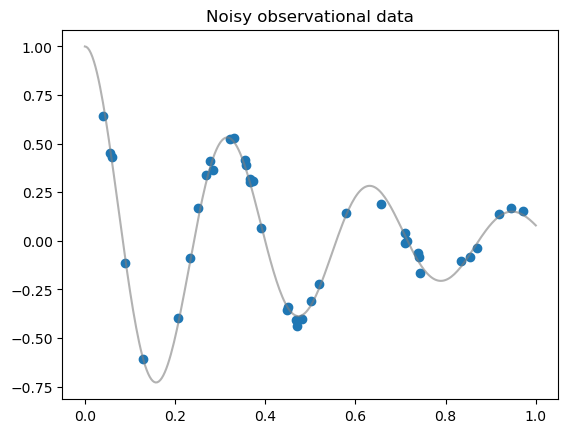

In [ ]:
# ENUNCIADO (NO CORRER!)

# Creamos data con ruido
d, w0 = 2, 20
print(f"True value of mu: {2*d}")

# Definimos los puntos observacionales para que la red aprenda de los datos
t_obs = #TODO
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

# definimos los puntos de entrenamiento sobre todo el dominio para la loss de la ecuacion diferencial
t_physics = #TODO

# parametros del problema
_, k = 2*d, w0**2

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

True value of mu: 4


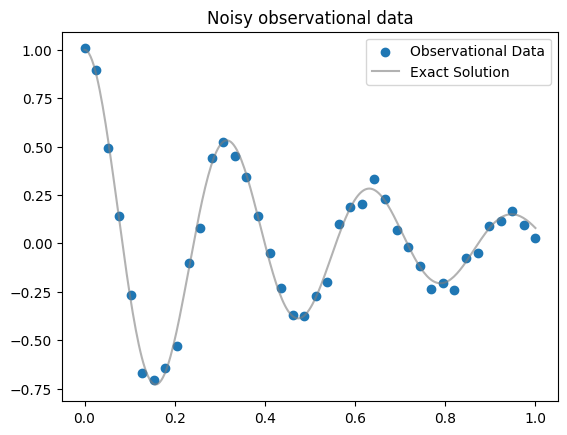

In [ ]:
# Creamos data con ruido
d, w0 = 2, 20
print(f"True value of mu: {2 * d}")

# Adjust the number of points
num_points = 40

# Definimos los puntos observacionales para que la red aprenda de los datos
t_obs = torch.linspace(0, 1, num_points).view(-1, 1)
u_obs = exact_solution(d, w0, t_obs) + 0.04 * torch.randn_like(t_obs)

# Definimos los puntos de entrenamiento sobre todo el dominio para la loss de la ecuacion diferencial
t_physics = torch.linspace(0, 1, num_points).view(-1, 1)

# Parámetros del problema
_, k = 2 * d, w0 ** 2

# Plotting
plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:, 0], u_obs[:, 0], label="Observational Data", color="tab:blue")
t_test, u_exact = torch.linspace(0, 1, 300).view(-1, 1), exact_solution(d, w0, t_test)
plt.plot(t_test[:, 0], u_exact[:, 0], label="Exact Solution", color="tab:grey", alpha=0.6)
plt.legend()
plt.show()


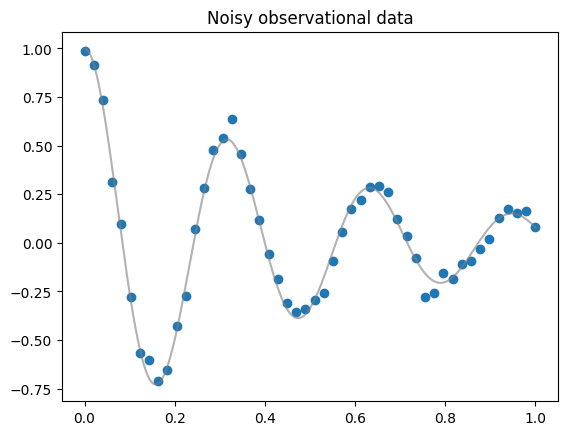

In [ ]:
# 3ro

# Generate Noisy Observational Data
t_obs = torch.linspace(0, 1, 50).view(-1, 1)  # Example: 50 evenly spaced points between 0 and 1
u_obs = exact_solution(d, w0, t_obs) + 0.04 * torch.randn_like(t_obs)

# Define Training Points for Differential Equation Loss
t_physics = torch.linspace(0, 1, 100).view(-1, 1)  # Example: 100 evenly spaced points between 0 and 1

# Plotting
plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:, 0], u_obs[:, 0])
t_test, u_exact = torch.linspace(0, 1, 300).view(-1, 1), exact_solution(d, w0, t_test)
plt.plot(t_test[:, 0], u_exact[:, 0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()


### Hiperparámetros y Modelo

In [ ]:
# Creamos un parametro entrenable para mumu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []

epochs = #TODO
pinn = #TODO
optim = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
lambda1 = 1e4

In [ ]:
# Creamos un parametro entrenable para mu
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))

# Lista para almacenar los valores de mu en cada época
mus = []

# Número de épocas
epochs = 15001

# Inicializamos la red neuronal y el optimizador
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optim = torch.optim.Adam(list(pinn.parameters()) + [mu], lr=1e-3)

# Coeficiente de regularización
lambda1 = 1e4

### Entrenamiento

In [ ]:
# Enunciado (No correr!)
for i in range(epochs):    # reseteamos el gradiente
    #TODO

    # Calculamos la perdida de la ecuacion diferencial
    u = #TODO
    dudt = #TODO
    d2udt2 = #TODO
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # Calculamos la perdida en funcion de los datos
    u = #TODO
    loss2 = torch.mean((u - u_obs)**2)

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2

    # Backward Pass
    #TODO

    # Actualizamos los pesos
    #TODO

    # guardamos el valor de mu
    mus.append(mu.item())

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

In [ ]:
for i in range(epochs):
    # Reseteamos el gradiente
    optim.zero_grad()

    # Calculamos la pérdida de la ecuación diferencial
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + mu * dudt + k * u)**2)

    # Calculamos la pérdida en función de los datos
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)

    # Calculamos la pérdida total (Custom Loss)
    loss = loss1 + lambda1 * loss2

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optim.step()

    # Guardamos el valor de mu
    mus.append(mu.item())

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6, 2.5))
        plt.scatter(t_obs[:, 0], u_obs[:, 0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

RuntimeError: ignored

### Estimacion de $\mu$

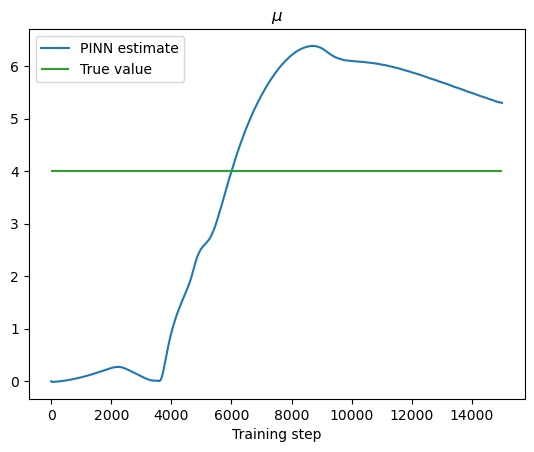

In [ ]:
# PAUTA (NO CORRER!!)
plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

## cómo escala la PINN a oscilaciones de mayor frecuencia



La tarea final es investigar cómo escala la PINN a oscilaciones de mayor frecuencia y qué se puede hacer para mejorar su convergencia.

Específicamente, volvemos a simular la solución al oscilador armónico e incrementamos su frecuencia, $\omega_0$.


la PINN lucha para converger, incluso si el número de puntos de entrenamiento físico aumenta.

Este es un problema más difícil para la PINN de resolver, en parte debido al **sesgo espectral** de las redes neuronales, así como al hecho de que se requieren más puntos de entrenamiento.

#### Enfoque: formulación alternativa "ansatz"

Para acelerar la convergencia, una forma es **asumir algo** sobre la solución.

Por ejemplo, supongamos que sabemos por nuestra intuición física que la solución es de hecho sinusoidal.

Entonces, en lugar de tener la PINN aproximando directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

En su lugar, usamos la PINN como parte de un ansatz matemático de la solución, es decir

$$
\hat u(t; \theta, \alpha, \beta) = u_{\mathrm{PINN}}(t;\theta)  \sin (\alpha t + \beta) \approx u(t)~,
$$

donde $\alpha, \beta$ se tratan como parámetros adicionales aprendibles.

Comparando este ansatz con la solución exacta

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))
$$

Vemos que ahora la PINN solo necesita aprender la función exponencial, lo cual debería ser un problema mucho más fácil.

¡Una vez más, la autodiferenciación nos permite diferenciar fácilmente a través de este ansatz para entrenar la PINN!


### Puntos de Entrenamiento

In [ ]:
# Enunciado

# Definimos los parametros A y B para la Ansatz
a = torch.nn.Parameter(70*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

# Definimos los puntos de borde
t_boundary = #TODO

# Definimos los puntos de entrenamiento sobre todo el dominio para la loss de la ecuacion diferencial
t_physics = #TODO

# Parametros del problema
d, w0 = 2, 80 # las oscilaciones (w0) aumentaron
mu, k = 2*d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

In [ ]:
# Definimos los parametros A y B para la Ansatz
a = torch.nn.Parameter(70 * torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

# Definimos los puntos de borde
t_boundary = torch.linspace(0, 1, 2).view(-1, 1).requires_grad_(True)  # Example: Two boundary points

# Definimos los puntos de entrenamiento sobre todo el dominio para la loss de la ecuacion diferencial
t_physics = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)  # Example: 100 physics domain points

# Parametros del problema
d, w0 = 2, 80  # las oscilaciones (w0) aumentaron
mu, k = 2 * d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

### Hiperparámetros y Modelo

In [ ]:
pinn = #TODO
optim = #TODO
lambda1, lambda2 = 1e-1, 1e-4

In [ ]:
# Define PINN
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=64, N_LAYERS=4)

# Adjust the learning rate
optim = torch.optim.Adam(list(pinn.parameters()) + [a, b], lr=1e-4)  # Experiment with different learning rates

lambda1, lambda2 = 1e-1, 1e-4

### Entrenamiento

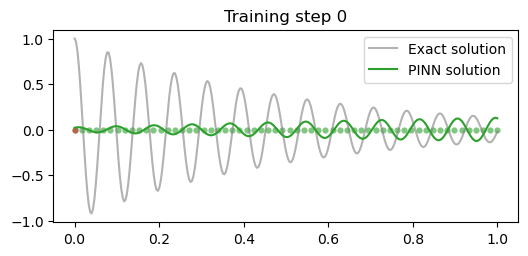

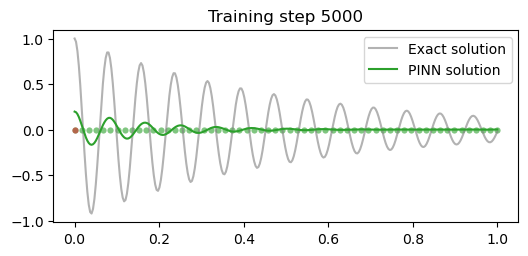

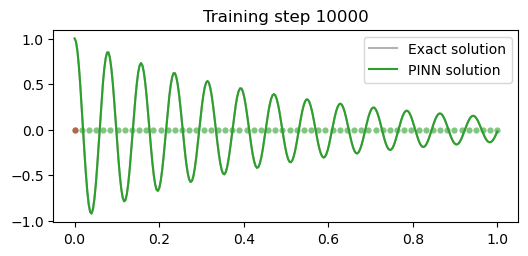

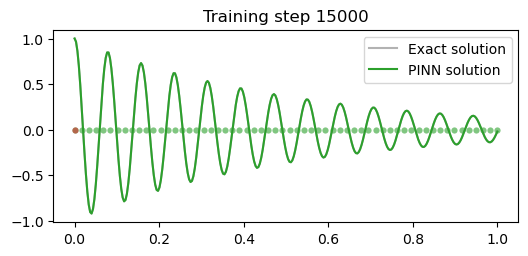

In [ ]:
for i in range(15001):
    # reseteamos el gradiente
    #TODO

    # Calculamos la perdida de la condicion de borde
    u = #TODO
    loss1 = #TODO
    dudt = #TODO
    loss2 = #TODO

    # Calculamos la perdida de la ecuacion diferencial
    u = #TODO
    dudt = #TODO
    d2udt2 = #TODO
    loss3 = #TODO

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2 + lambda2*loss3

    # Backward Pass
    #TODO

    # Actualizamos los pesos
    #TODO

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = (pinn(t_test)*torch.sin(a*t_test+b)).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

In [ ]:
for i in range(20000):
    # Reseteamos el gradiente
    optim.zero_grad()

    # Calculamos la pérdida de la condición de borde
    u = (pinn(t_boundary) * torch.sin(a * t_boundary + b))
    loss1 = torch.mean((u - 0)**2)
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = torch.mean((dudt - 0)**2)

    # Calculamos la pérdida de la ecuación diferencial
    u = (pinn(t_physics) * torch.sin(a * t_physics + b))
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu * dudt + k * u)**2)

    # Calculamos la pérdida total (Custom Loss)
    loss = loss1 + lambda1 * loss2 + lambda2 * loss3

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optim.step()

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = (pinn(t_test) * torch.sin(a * t_test + b)).detach().numpy()
        plt.figure(figsize=(6, 2.5))
        plt.scatter(t_physics.detach()[:, 0],
                    torch.zeros_like(t_physics)[:, 0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:, 0],
                    torch.zeros_like(t_boundary)[:, 0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:, 0], u_exact[:, 0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()